# Assignment: Segmenting and Clustering Neighborhoods in Toronto

In this assignment, We will be required to explore, segment, and cluster the neighborhoods in the city of Toronto. However, unlike New York, the neighborhood data is not readilyavailable on the internet. What is interesting about the field of data science is that each project can be challenging in its unique way, so you need to learn to be agile and refine the skill to learn new libraries and tools quickly depending on the project.

For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. You will be required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format like the New York dataset. Once the data is in a structured format, We can replicate the analysis that we did to the New York City dataset to explore and cluster the neighborhoods in the city of Toronto.

##### 1.	Start by creating a new Notebook for this assignment. -  This notebook

(We have to prepare one notebook for all three parts of this assighment, but please use Markdown to clearly label your work for each part in order to make it easy for your peers to grade your work. However, you will have to submit the notebook three times since a submission has to be associated with each question.)

In [1]:
#Import necessary libraries
import pandas as pd # library for data analsysis
from bs4 import BeautifulSoup # library for pulling data out of HTML and XML files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('All Libraries imported.')


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.0               |             py_0          26 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                       

2. Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe, which will consist of three columns: PostalCode, Borough, and Neighborhood

In [2]:
# Upload the Wikipedia page
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source,'lxml')

In [3]:
# Find the Table on the Wikipedia page and iterate through tags for required information
table_can = soup.find('table')
col = table_can.find_all('td')

elem_cnt = len(col)

# create three lists to store table data
postcode = []
borough = []
neighborhood = []

for i in range(0, elem_cnt, 3):
    postcode.append(col[i].text.strip())
    borough.append(col[i+1].text.strip())
    neighborhood.append(col[i+2].text.strip())

In [4]:
# create a new DataFrame from our lists
toronto_df = pd.DataFrame({"PostalCode": postcode,
                           "Borough": borough,
                           "Neighborhood": neighborhood})

toronto_df.head()

PostalCode           Borough                Neighborhood
0        M1A      Not assigned                            
1        M2A      Not assigned                            
2        M3A        North York                   Parkwoods
3        M4A        North York            Victoria Village
4        M5A  Downtown Toronto  Regent Park / Harbourfront

##### Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [5]:
# Normalize data and transform to given requirements
toronto_df_dropna = toronto_df[toronto_df.Borough != "Not assigned"].reset_index(drop=True)
toronto_df.loc[toronto_df.Neighborhood == 'Not assigned', "Neighborhood"] = toronto_df.Borough

#Group data by Postcode & Borough
toronto_df_grouped = toronto_df_dropna.groupby(["PostalCode", "Borough"], as_index=False).agg(lambda x: ", ".join(x))

# for Neighborhood="Not assigned", make the value the same as Borough
for index, row in toronto_df_grouped.iterrows():
    if row["Neighborhood"] == "Not assigned":
        row["Neighborhood"] = row["Borough"]

##### More than one neighborhood can exist in one postal code area. These two rows will be combined into one row with the neighborhoods separated with a comma 

In [6]:
# create a new dataframe to met the assignement's requirements
column_names = ["PostalCode", "Borough", "Neighborhood"]
neighborhoods_df = pd.DataFrame(columns=column_names)

neighborhoods_list = ["M5G", "M2H", "M4B", "M1J", "M4G", "M4M", "M1R", "M9V", "M9L", "M5V", "M1B", "M5A"]

for postcode in neighborhoods_list:
    neighborhoods_df = neighborhoods_df.append(toronto_df_grouped[toronto_df_grouped["PostalCode"]==postcode], ignore_index=True)
    
neighborhoods_df

PostalCode           Borough  \
0         M5G  Downtown Toronto   
1         M2H        North York   
2         M4B         East York   
3         M1J       Scarborough   
4         M4G         East York   
5         M4M      East Toronto   
6         M1R       Scarborough   
7         M9V         Etobicoke   
8         M9L        North York   
9         M5V  Downtown Toronto   
10        M1B       Scarborough   
11        M5A  Downtown Toronto   

                                         Neighborhood  
0                                  Central Bay Street  
1                                   Hillcrest Village  
2                    Parkview Hill / Woodbine Gardens  
3                                 Scarborough Village  
4                                             Leaside  
5                                     Studio District  
6                                  Wexford / Maryvale  
7   South Steeles / Silverstone / Humbergate / Jam...  
8                                       Humber Summit  
9   CN Tower / King and Spadina / Railway Lands / ...  
10                                    Malvern / Rouge  
11                         Regent Park / Harbourfront

##### use the .shape method to print the number of rows of your dataframe.

In [7]:
# print the number of rows of the cleaned dataframe
toronto_df_grouped.shape

(103, 3)

***

##### Get the latitude and the longitude coordinates of each neighborhood from the csv file from "http://cocl.us/Geospatial_data"

In [8]:
# load coordinates from the csv file 
coordinates = pd.read_csv("http://cocl.us/Geospatial_data")
coordinates.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

Now we arrange the dataframe for the Assignment requirement

In [9]:
# rename the column "PostalCode"
coordinates.rename(columns={"Postal Code": "PostalCode"}, inplace=True)

# merge two table on the column "PostalCode" 
toronto_df_new = toronto_df_grouped.merge(coordinates, on="PostalCode", how="left")
toronto_df_new.head()

PostalCode      Borough                              Neighborhood  \
0        M1B  Scarborough                           Malvern / Rouge   
1        M1C  Scarborough  Rouge Hill / Port Union / Highland Creek   
2        M1E  Scarborough       Guildwood / Morningside / West Hill   
3        M1G  Scarborough                                    Woburn   
4        M1H  Scarborough                                 Cedarbrae   

    Latitude  Longitude  
0  43.806686 -79.194353  
1  43.784535 -79.160497  
2  43.763573 -79.188711  
3  43.770992 -79.216917  
4  43.773136 -79.239476

In [10]:
# create a new dataframe to met the assignement's requirements
column_names = ["PostalCode", "Borough", "Neighborhood", "Latitude", "Longitude"]
neighborhoods_coord_df = pd.DataFrame(columns=column_names)

neighborhoods_list = ["M5G", "M2H", "M4B", "M1J", "M4G", "M4M", "M1R", "M9V", "M9L", "M5V", "M1B", "M5A"]

for postcode in neighborhoods_list:
    neighborhoods_coord_df = neighborhoods_coord_df.append(toronto_df_new[toronto_df_new["PostalCode"]==postcode], ignore_index=True)
    
neighborhoods_coord_df

PostalCode           Borough  \
0         M5G  Downtown Toronto   
1         M2H        North York   
2         M4B         East York   
3         M1J       Scarborough   
4         M4G         East York   
5         M4M      East Toronto   
6         M1R       Scarborough   
7         M9V         Etobicoke   
8         M9L        North York   
9         M5V  Downtown Toronto   
10        M1B       Scarborough   
11        M5A  Downtown Toronto   

                                         Neighborhood   Latitude  Longitude  
0                                  Central Bay Street  43.657952 -79.387383  
1                                   Hillcrest Village  43.803762 -79.363452  
2                    Parkview Hill / Woodbine Gardens  43.706397 -79.309937  
3                                 Scarborough Village  43.744734 -79.239476  
4                                             Leaside  43.709060 -79.363452  
5                                     Studio District  43.659526 -79.340923  
6                                  Wexford / Maryvale  43.750072 -79.295849  
7   South Steeles / Silverstone / Humbergate / Jam...  43.739416 -79.588437  
8                                       Humber Summit  43.756303 -79.565963  
9   CN Tower / King and Spadina / Railway Lands / ...  43.628947 -79.394420  
10                                    Malvern / Rouge  43.806686 -79.194353  
11                         Regent Park / Harbourfront  43.654260 -79.360636

***

# Explore and cluster the neighborhoods in Toronto

***

### Get the latitude and longitude values of Toronto from geopy library

In [11]:
address = 'Toronto, Ca'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


##### Now We can create the Map of Toronto with assignment requirement 

In [12]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods_coord_df['Latitude'], neighborhoods_coord_df['Longitude'], neighborhoods_coord_df['Borough'], neighborhoods_coord_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### In the IBM Watson Studio Assignment get the following fig 

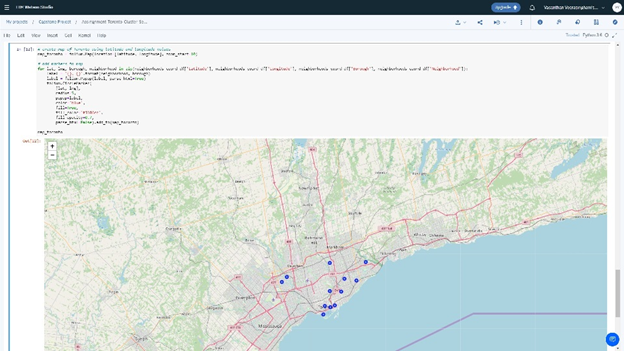

### Use the Foursquare API to explore the neighborhoods and segment them

In [13]:
# Define Foursquare Credentials and Version
LIMIT = 25

CLIENT_ID = 'BC02ZFLGQHUGGN0U4WEGGRODRU0WQTSNZPKOCR0TB3ELVAAT' # your Foursquare ID
CLIENT_SECRET = 'MOJ3DJ52AXY3WWSWCSAEJWXFAVB3XI0CUHGIQ0XOVPWS14QB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [14]:
#neighborhoods_coord_df.loc[0, 'Neighborhood']

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Now write the code to run the above function on each neighborhood and create a new dataframe called toronto_venues.

In [16]:
toronto_venues = getNearbyVenues(names=neighborhoods_coord_df['Neighborhood'],
                                   latitudes=neighborhoods_coord_df['Latitude'],
                                   longitudes=neighborhoods_coord_df['Longitude']
                                  )

Central Bay Street
Hillcrest Village
Parkview Hill / Woodbine Gardens
Scarborough Village
Leaside
Studio District
Wexford / Maryvale
South Steeles / Silverstone / Humbergate / Jamestown / Mount Olive / Beaumond Heights / Thistletown / Albion Gardens
Humber Summit
CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst
 Quay / South Niagara / Island airport
Malvern / Rouge
Regent Park / Harbourfront


##### Check the size of the dataframe

In [17]:
print(toronto_venues.shape)
toronto_venues.head()

(155, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Central Bay Street              43.657952              -79.387383   
1  Central Bay Street              43.657952              -79.387383   
2  Central Bay Street              43.657952              -79.387383   
3  Central Bay Street              43.657952              -79.387383   
4  Central Bay Street              43.657952              -79.387383   

                               Venue  Venue Latitude  Venue Longitude  \
0                     Jimmy's Coffee       43.658421       -79.385613   
1                        Tim Hortons       43.658570       -79.385123   
2                     Neo Coffee Bar       43.660140       -79.385870   
3                      Hailed Coffee       43.658833       -79.383684   
4  The Queen and Beaver Public House       43.657472       -79.383524   

  Venue Category  
0    Coffee Shop  
1    Coffee Shop  
2    Coffee Shop  
3    Coffee Shop  
4      Gastropub

##### Let's check how many venues were returned for each neighborhood

In [18]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
CN Tower / King and Spadina / Railway Lands / H...                     17   
Central Bay Street                                                     25   
Hillcrest Village                                                       5   
Humber Summit                                                           1   
Leaside                                                                25   
Malvern / Rouge                                                         1   
Parkview Hill / Woodbine Gardens                                       13   
Regent Park / Harbourfront                                             25   
Scarborough Village                                                     2   
South Steeles / Silverstone / Humbergate / Jame...                     12   
Studio District                                                        25   
Wexford / Maryvale                                                      4   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
CN Tower / King and Spadina / Railway Lands / H...                      17   
Central Bay Street                                                      25   
Hillcrest Village                                                        5   
Humber Summit                                                            1   
Leaside                                                                 25   
Malvern / Rouge                                                          1   
Parkview Hill / Woodbine Gardens                                        13   
Regent Park / Harbourfront                                              25   
Scarborough Village                                                      2   
South Steeles / Silverstone / Humbergate / Jame...                      12   
Studio District                                                         25   
Wexford / Maryvale                                                       4   

                                                    Venue  Venue Latitude  \
Neighborhood                                                                
CN Tower / King and Spadina / Railway Lands / H...     17              17   
Central Bay Street                                     25              25   
Hillcrest Village                                       5               5   
Humber Summit                                           1               1   
Leaside                                                25              25   
Malvern / Rouge                                         1               1   
Parkview Hill / Woodbine Gardens                       13              13   
Regent Park / Harbourfront                             25              25   
Scarborough Village                                     2               2   
South Steeles / Silverstone / Humbergate / Jame...     12              12   
Studio District                                        25              25   
Wexford / Maryvale                                      4               4   

                                                    Venue Longitude  \
Neighborhood                                                          
CN Tower / King and Spadina / Railway Lands / H...               17   
Central Bay Street                                               25   
Hillcrest Village                                                 5   
Humber Summit                                                     1   
Leaside                                                          25   
Malvern / Rouge                                                   1   
Parkview Hill / Woodbine Gardens                                 13   
Regent Park / Harbourfront                                       25   
Scarborough Village                                               2   
South Steeles / Silv

### Let's find out how many unique categories can be curated from all the returned venues

In [19]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 89 uniques categories.


## Analyze Each Neighborhood

In [20]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

Wine Bar  Airport  Airport Food Court  Airport Gate  Airport Lounge  \
0         0        0                   0             0               0   
1         0        0                   0             0               0   
2         0        0                   0             0               0   
3         0        0                   0             0               0   
4         0        0                   0             0               0   

   Airport Service  Airport Terminal  American Restaurant  Athletics & Sports  \
0                0                 0                    0                   0   
1                0                 0                    0                   0   
2                0                 0                    0                   0   
3                0                 0                    0                   0   
4                0                 0                    0                   0   

   Bakery  ...  Smoke Shop  Spa  Sporting Goods Shop  Sports Bar  \
0       0  ...           0    0                    0           0   
1       0  ...           0    0                    0           0   
2       0  ...           0    0                    0           0   
3       0  ...           0    0                    0           0   
4       0  ...           0    0                    0           0   

   Stationery Store  Steakhouse  Supermarket  Sushi Restaurant  Tea Room  \
0                 0           0            0                 0         0   
1                 0           0            0                 0         0   
2                 0           0            0                 0         0   
3                 0           0            0                 0         0   
4                 0           0            0                 0         0   

   Thai Restaurant  
0                0  
1                0  
2                0  
3                0  
4                0  

[5 rows x 89 columns]

##### And let's examine the new dataframe size.

In [21]:
toronto_onehot.shape

(155, 89)

### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [22]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

Neighborhood  Wine Bar   Airport  \
0   CN Tower / King and Spadina / Railway Lands / ...      0.00  0.058824   
1                                  Central Bay Street      0.00  0.000000   
2                                   Hillcrest Village      0.00  0.000000   
3                                       Humber Summit      0.00  0.000000   
4                                             Leaside      0.00  0.000000   
5                                     Malvern / Rouge      0.00  0.000000   
6                    Parkview Hill / Woodbine Gardens      0.00  0.000000   
7                          Regent Park / Harbourfront      0.00  0.000000   
8                                 Scarborough Village      0.00  0.000000   
9   South Steeles / Silverstone / Humbergate / Jam...      0.00  0.000000   
10                                    Studio District      0.04  0.000000   
11                                 Wexford / Maryvale      0.00  0.000000   

    Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0             0.058824      0.058824        0.117647         0.176471   
1             0.000000      0.000000        0.000000         0.000000   
2             0.000000      0.000000        0.000000         0.000000   
3             0.000000      0.000000        0.000000         0.000000   
4             0.000000      0.000000        0.000000         0.000000   
5             0.000000      0.000000        0.000000         0.000000   
6             0.000000      0.000000        0.000000         0.000000   
7             0.000000      0.000000        0.000000         0.000000   
8             0.000000      0.000000        0.000000         0.000000   
9             0.000000      0.000000        0.000000         0.000000   
10            0.000000      0.000000        0.000000         0.000000   
11            0.000000      0.000000        0.000000         0.000000   

    Airport Terminal  American Restaurant  Athletics & Sports  ...  \
0           0.117647                 0.00            0.000000  ...   
1           0.000000                 0.00            0.000000  ...   
2           0.000000                 0.00            0.000000  ...   
3           0.000000                 0.00            0.000000  ...   
4           0.000000                 0.00            0.000000  ...   
5           0.000000                 0.00            0.000000  ...   
6           0.000000                 0.00            0.076923  ...   
7           0.000000                 0.00            0.000000  ...   
8           0.000000                 0.00            0.000000  ...   
9           0.000000                 0.00            0.000000  ...   
10          0.000000                 0.04            0.000000  ...   
11          0.000000                 0.00            0.000000  ...   

    Smoke Shop   Spa  Sporting Goods Shop  Sports Bar  Stationery Store  \
0         0.00  0.00                 0.00        0.00              0.00   
1         0.00  0.04                 0.00        0.00              0.00   
2         0.00  0.00                 0.00        0.00              0.00   
3         0.00  0.00                 0.00        0.00              0.00   
4         0.00  0.00                 0.12        0.04              0.00   
5         0.00  0.00                 0.00        0.00              0.00   
6         0.00  0.00                 0.00        0.00              0.00   
7         0.00  0.04                 0.00        0.00              0.00   
8         0.00  0.00                 0.00        0.00              0.00   
9         0.00  0.00                 0.00        0.00              0.00   
10        0.00  0.00                 0.00        0.00              0.04   
11        0.25  0.00                 0.00        0.00              0.00   

    Steakhouse  Supermarket  Sushi Restaurant  Tea Room  Thai Restaurant  
0         0.00         0.00              0.00      0.00             0.00  
1         0.04         0.00              0.04      0

### Confirm the new size

In [23]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst
 Quay / South Niagara / Island airport----
                 venue  freq
0      Airport Service  0.18
1       Airport Lounge  0.12
2     Airport Terminal  0.12
3  Rental Car Location  0.06
4                  Bar  0.06


----Central Bay Street----
                 venue  freq
0          Coffee Shop  0.24
1   Italian Restaurant  0.08
2  Japanese Restaurant  0.08
3                  Bar  0.04
4     Ramen Restaurant  0.04


----Hillcrest Village----
                      venue  freq
0               Golf Course   0.2
1      Fast Food Restaurant   0.2
2                      Pool   0.2
3  Mediterranean Restaurant   0.2
4                   Dog Run   0.2


----Humber Summit----
                      venue  freq
0       Empanada Restaurant   1.0
1                  Wine Bar   0.0
2  Mediterranean Restaurant   0.0
3                  Pharmacy   0.0
4                 Pet Store   0.0


----Leaside----
                 venue 

### Put dataframe into a pandas and write a function to sort the venues in descending order

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

##### Create the new dataframe and display the top 10 venues for each neighborhood

In [25]:
import numpy as np # library to handle data in a vectorized manner

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0  CN Tower / King and Spadina / Railway Lands / ...       Airport Service   
1                                 Central Bay Street           Coffee Shop   
2                                  Hillcrest Village           Golf Course   
3                                      Humber Summit   Empanada Restaurant   
4                                            Leaside           Coffee Shop   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0        Airport Lounge      Airport Terminal              Boutique   
1    Italian Restaurant   Japanese Restaurant    Seafood Restaurant   
2  Fast Food Restaurant                  Pool               Dog Run   
3       Thai Restaurant          Dessert Shop           Cheese Shop   
4   Sporting Goods Shop          Burger Joint     Fish & Chips Shop   

      5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0       Rental Car Location               Airport    Airport Food Court   
1                Poke Place                   Bar    Chinese Restaurant   
2  Mediterranean Restaurant       Thai Restaurant       Coworking Space   
3        Chinese Restaurant        Chocolate Shop           Coffee Shop   
4            Sandwich Place             Juice Bar               Brewery   

     8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0             Airport Gate         Boat or Ferry                  Plane  
1         Ramen Restaurant        Sandwich Place        Bubble Tea Shop  
2              Cheese Shop    Chinese Restaurant         Chocolate Shop  
3  Comfort Food Restaurant     Convenience Store        Coworking Space  
4                Pet Store             Bike Shop                   Bank

### Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters

In [26]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 2, 1, 0, 1, 1, 1, 1], dtype=int32)

##### Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

toronto_merged = neighborhoods_coord_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

PostalCode           Borough                      Neighborhood   Latitude  \
0        M5G  Downtown Toronto                Central Bay Street  43.657952   
1        M2H        North York                 Hillcrest Village  43.803762   
2        M4B         East York  Parkview Hill / Woodbine Gardens  43.706397   
3        M1J       Scarborough               Scarborough Village  43.744734   
4        M4G         East York                           Leaside  43.709060   

   Longitude  Cluster Label 1st Most Common Venue 2nd Most Common Venue  \
0 -79.387383              1           Coffee Shop    Italian Restaurant   
1 -79.363452              1           Golf Course  Fast Food Restaurant   
2 -79.309937              1           Pizza Place              Pharmacy   
3 -79.239476              1            Playground     Convenience Store   
4 -79.363452              1           Coffee Shop   Sporting Goods Shop   

  3rd Most Common Venue 4th Most Common Venue     5th Most Common Venue  \
0   Japanese Restaurant    Seafood Restaurant                Poke Place   
1                  Pool               Dog Run  Mediterranean Restaurant   
2    Athletics & Sports              Bus Line                 Pet Store   
3       Thai Restaurant              Bus Line               Cheese Shop   
4          Burger Joint     Fish & Chips Shop            Sandwich Place   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                   Bar    Chinese Restaurant      Ramen Restaurant   
1       Thai Restaurant       Coworking Space           Cheese Shop   
2        Breakfast Spot                  Bank          Intersection   
3    Chinese Restaurant        Chocolate Shop           Coffee Shop   
4             Juice Bar               Brewery             Pet Store   

     9th Most Common Venue 10th Most Common Venue  
0           Sandwich Place        Bubble Tea Shop  
1       Chinese Restaurant         Chocolate Shop  
2                     Café              Gastropub  
3  Comfort Food Restaurant        Coworking Space  
4                Bike Shop                   Bank

### Finally, let's visualize the resulting clusters

In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


### Examine Clusters

Examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, let's then assign a name to each cluster.


### Cluster 1

In [29]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Label 1st Most Common Venue 2nd Most Common Venue  \
10  Scarborough              0  Fast Food Restaurant       Thai Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
10          Dessert Shop           Cheese Shop    Chinese Restaurant   

   6th Most Common Venue 7th Most Common Venue    8th Most Common Venue  \
10        Chocolate Shop           Coffee Shop  Comfort Food Restaurant   

   9th Most Common Venue 10th Most Common Venue  
10     Convenience Store        Coworking Space

### Cluster 2

In [30]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Label 1st Most Common Venue  \
0   Downtown Toronto              1           Coffee Shop   
1         North York              1           Golf Course   
2          East York              1           Pizza Place   
3        Scarborough              1            Playground   
4          East York              1           Coffee Shop   
5       East Toronto              1           Coffee Shop   
6        Scarborough              1        Breakfast Spot   
7          Etobicoke              1         Grocery Store   
9   Downtown Toronto              1       Airport Service   
11  Downtown Toronto              1           Coffee Shop   

        2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0          Italian Restaurant   Japanese Restaurant    Seafood Restaurant   
1        Fast Food Restaurant                  Pool               Dog Run   
2                    Pharmacy    Athletics & Sports              Bus Line   
3           Convenience Store       Thai Restaurant              Bus Line   
4         Sporting Goods Shop          Burger Joint     Fish & Chips Shop   
5                      Bakery                  Café       Thai Restaurant   
6   Middle Eastern Restaurant            Smoke Shop                Bakery   
7                 Pizza Place              Pharmacy        Sandwich Place   
9              Airport Lounge      Airport Terminal              Boutique   
11                       Park                Bakery    Mexican Restaurant   

       5th Most Common Venue  6th Most Common Venue 7th Most Common Venue  \
0                 Poke Place                    Bar    Chinese Restaurant   
1   Mediterranean Restaurant        Thai Restaurant       Coworking Space   
2                  Pet Store         Breakfast Spot                  Bank   
3                Cheese Shop     Chinese Restaurant        Chocolate Shop   
4             Sandwich Place              Juice Bar               Brewery   
5                  Pet Store    American Restaurant             Bookstore   
6            Thai Restaurant           Dessert Shop    Chinese Restaurant   
7       Fast Food Restaurant         Discount Store   Japanese Restaurant   
9        Rental Car Location                Airport    Airport Food Court   
11            Breakfast Spot  Performing Arts Venue        Chocolate Shop   

   8th Most Common Venue    9th Most Common Venue   10th Most Common Venue  
0       Ramen Restaurant           Sandwich Place          Bubble Tea Shop  
1            Cheese Shop       Chinese Restaurant           Chocolate Shop  
2           Intersection                     Café                Gastropub  
3            Coffee Shop  Comfort Food Restaurant          Coworking Space  
4              Pet Store                Bike Shop                     Bank  
5                Brewery              Cheese Shop  Comfort Food Restaurant  
6         Chocolate Shop              Coffee Shop  Comfort Food Restaurant  
7           Liquor Store               Beer Store      Fried Chicken Joint  
9           Airport Gate            Boat or Ferry                    Plane  
11                   Pub               Restaurant                     Café

### Cluster 3

In [31]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Label 1st Most Common Venue 2nd Most Common Venue  \
8  North York              2   Empanada Restaurant       Thai Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
8          Dessert Shop           Cheese Shop    Chinese Restaurant   

  6th Most Common Venue 7th Most Common Venue    8th Most Common Venue  \
8        Chocolate Shop           Coffee Shop  Comfort Food Restaurant   

  9th Most Common Venue 10th Most Common Venue  
8     Convenience Store        Coworking Space

### There are 3 Clusters Clusters 2 is the biggest and have 12 neighbourhood, cluster 1 and clusters 3 have just one neighbourhood each

*****